In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

import statsmodels.api as sm
from random import random

import warnings

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# Задача 1

Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

In [3]:
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


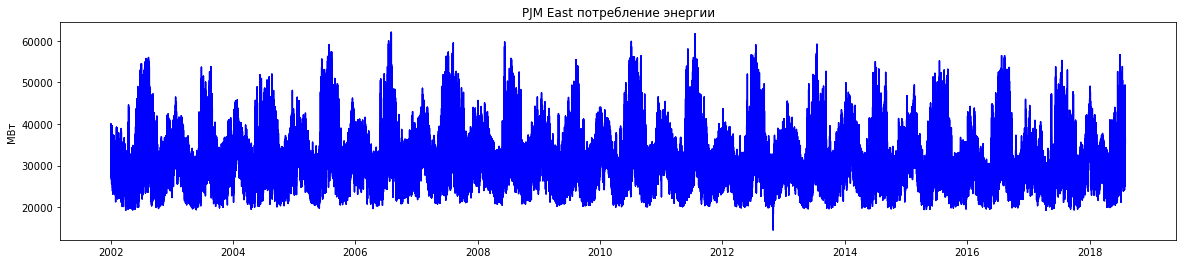

In [4]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Построим сразу три ресемплинга, чтобы выявить циклы, для последующего построяние модели SARIMAX 

In [5]:
data_d = data.copy().resample('D').mean()
data_m = data.resample('M').mean()
data_w = data.resample('W').mean()
data_Y = data.resample('3M').mean()

Постмотрим получившийся график 

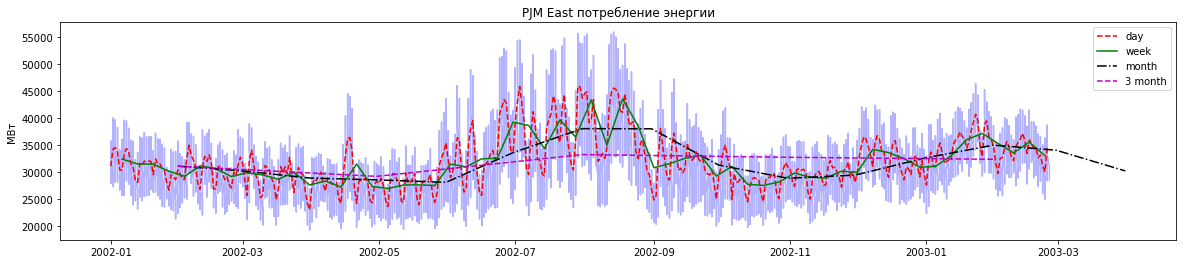

In [6]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_d.index[:5*7*4*3], data_d['PJME_MW'].values[:5*7*4*3], '--r',label='day' )
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.plot( data_Y.index[:5], data_Y['PJME_MW'].values[:5], '--m',label='3 month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

По графику видна странная аномалия в конце 4 месяца 2002 года. 

# Задача 2

Подберите параметры модели SARIMAX для этого ряда

Посмтроим график автокореляции и частной автокореляции. 

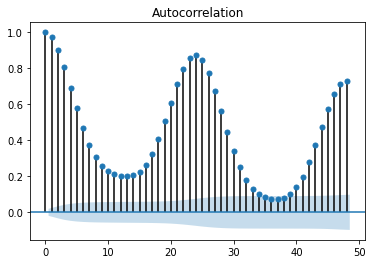

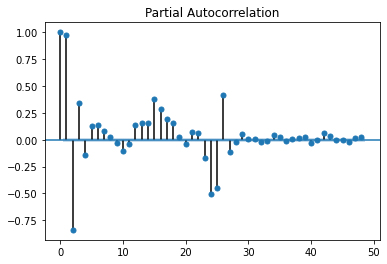

In [7]:
sm.graphics.tsa.plot_acf(data['PJME_MW'].values[:10000], lags=24*2)
plt.show()

sm.graphics.tsa.plot_pacf(data['PJME_MW'].values[:10000], lags=24*2)
plt.show()

По графику автокореляции видим, что есть цикличность и сильная кореляция с лагов в 24, то есть нужен параметр M(24).
По второму графику можно сказать, что есть нестационарность и необходимо ее отделить от нашего ряда.

Посмотрим ресемплинг на дневные данные, т.е. сгладим наш ряд по упрощенной схеме.

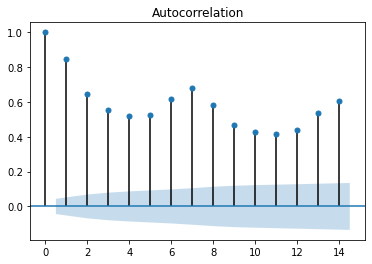

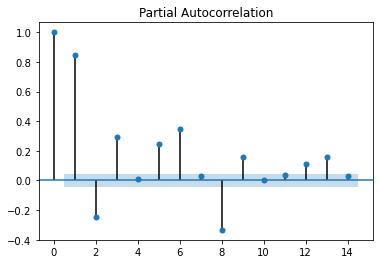

In [8]:
sm.graphics.tsa.plot_acf(data_d['PJME_MW'].values[:2000], lags=14)
plt.show()
sm.graphics.tsa.plot_pacf(data_d['PJME_MW'].values[:2000], lags=14)
plt.show()

Картина примерно таже. Видим довольную сильную кореляцию с недельным лагом. И необходимость брать вторую производную. 

 Практически аналогично выглядит картинка и для разностей(PACF) т.е. есть значительная по 1-му остатку (AR 1) и более слабые связи по неделям (до AR 8 ). Посмотрим как выглядит ряд при ресемплинге на 3-месячных данных.

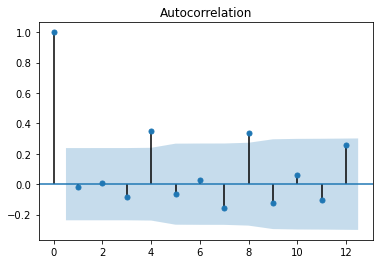

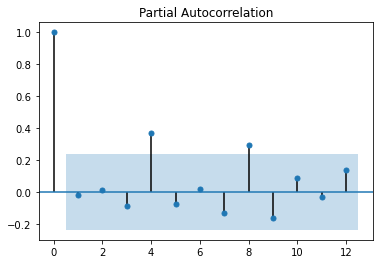

In [9]:
sm.graphics.tsa.plot_acf(data_Y['PJME_MW'].values, lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(data_Y['PJME_MW'].values, lags=12)
plt.show()

На трехмесячном графике можно увидеть, что есть ежегодный цикл (лаг 4 и 8) для ACF (МА 4) и PACF (AR 4). Это годовые сезонные изменения по всем периоду наблюдений. Аналогичную картину можно увидеть для оценки автокорреляций на месячных данных:


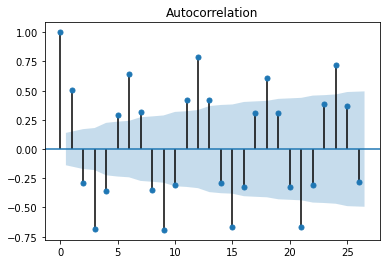

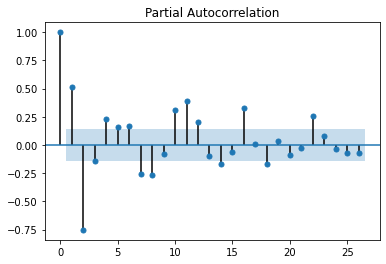

In [10]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=26)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=26)
plt.show()

Тут мы видим не только кореляцию по 6 месяцев, но еще и сильную антикореляцию с 4 месяца.

Сохраняется корреляция для квартальных лагов (3, 6, 9 и 12 месяцы - это наши сезонные колебания - ACF) и для разностей важными являются значения внутри первых 3-х значений (PACF). Это позволит определить, что ряд сезонный и следует использовать модель сезонности с периодом 12, 6 или 3 месяца. диапазон поиска параметров модели ARIMA для лучшего описания нашего ряда в диапазоне до первых разностей и сглаживаний первого порядка.

Общая рекомендация для оценки параметров:

    p = 1 : ACF - экспоненциально убывает, PACF - имеет резко выделяющееся значение для лага 1, нет корреляций на других лагах.

    p = 2 : ACF имеет форму синусоиды или экспоненциально убывает, PACF имеет резко выделяющиеся значения на лагах 1, 2, нет корреляций на других лагах.

    q = 1: ACF имеет резко выделяющееся значение на лаге 1, нет корреляций на других лагах, PACF экспоненциально убывает.

    q = 2: ACF имеет резко выделяющиеся значения на лагах 1, 2, нет корреляций на других лагах, PACF имеет форму синусоиды или экспоненциально убывает.

    p = 1 и q = 1: ACF экспоненциально убывает с лага 1, PACF - экспоненциально убывает с лага 1.



В сезонных рядах ACF и PACF имеют существенные значения на лагах, кратных сезонному лагу.

### Посмотрим на модель месячного ресемплинга. ACF

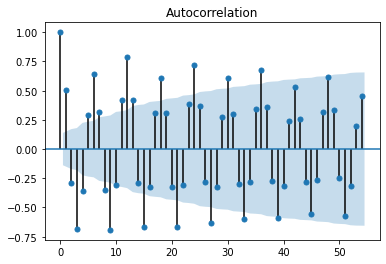

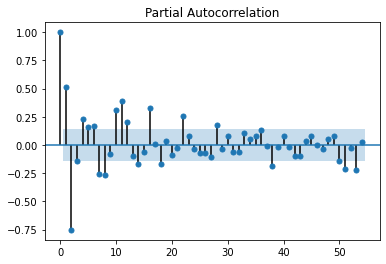

In [11]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values[:300], lags=54)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values[:300], lags=54)
plt.show()


In [12]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2002-01-31 to 2018-08-31
Freq: M
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PJME_MW          200 non-null    float64
 1   year             200 non-null    float64
 2   month            200 non-null    float64
 3   dayofmonth       200 non-null    float64
 4   quarter          200 non-null    float64
 5   dayofyear        200 non-null    float64
 6   weekofyear       200 non-null    float64
 7   dayofweek        200 non-null    float64
 8   hour             200 non-null    float64
 9   is_holiday       200 non-null    float64
 10  is_prev_holiday  200 non-null    float64
 11  is_next_holiday  200 non-null    float64
dtypes: float64(12)
memory usage: 20.3 KB


###  Опредилить параметры модели 

p = 2 : ACF имеет форму синусоиды или экспоненциально убывает, PACF имеет резко выделяющиеся значения на лагах 1, 2, нет корреляций на других лагах.

In [13]:
import itertools

p = range(0, 3)
d = range(0, 3)
q = range(0, 3)

m = [12]

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], x[3] ) for x in list(itertools.product(p, d, q , m))]

In [14]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-30],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)3 - AIC:3992.5110075928433
ARIMA(0, 0, 0)x(0, 0, 1, 12)3 - AIC:3604.136774693245
ARIMA(0, 0, 0)x(0, 0, 2, 12)3 - AIC:3307.3157105213454
ARIMA(0, 0, 0)x(0, 1, 0, 12)3 - AIC:2823.40519565099
ARIMA(0, 0, 0)x(0, 1, 1, 12)3 - AIC:2598.6895974048693
ARIMA(0, 0, 0)x(0, 1, 2, 12)3 - AIC:2365.3245731795346
ARIMA(0, 0, 0)x(0, 2, 0, 12)3 - AIC:2759.2770606314034
ARIMA(0, 0, 0)x(0, 2, 1, 12)3 - AIC:2479.0128573859465
ARIMA(0, 0, 0)x(0, 2, 2, 12)3 - AIC:2246.623927870588
ARIMA(0, 0, 0)x(1, 0, 0, 12)3 - AIC:2846.1162304291183
ARIMA(0, 0, 0)x(1, 0, 1, 12)3 - AIC:2826.005505905165
ARIMA(0, 0, 0)x(1, 0, 2, 12)3 - AIC:2574.8196730610807
ARIMA(0, 0, 0)x(1, 1, 0, 12)3 - AIC:2605.476783568567
ARIMA(0, 0, 0)x(1, 1, 1, 12)3 - AIC:2588.307590956343
ARIMA(0, 0, 0)x(1, 1, 2, 12)3 - AIC:2361.6550720953474
ARIMA(0, 0, 0)x(1, 2, 0, 12)3 - AIC:2496.362682200949
ARIMA(0, 0, 0)x(1, 2, 1, 12)3 - AIC:2466.62123659233
ARIMA(0, 0, 0)x(1, 2, 2, 12)3 - AIC:2228.5679311082167
ARIMA(0, 0, 0)x(2, 0

ARIMA(0, 1, 2)x(1, 2, 1, 12)3 - AIC:2350.3721490936355
ARIMA(0, 1, 2)x(1, 2, 2, 12)3 - AIC:2118.7668541799035
ARIMA(0, 1, 2)x(2, 0, 0, 12)3 - AIC:2577.4092631587755
ARIMA(0, 1, 2)x(2, 0, 1, 12)3 - AIC:2559.6011055195213
ARIMA(0, 1, 2)x(2, 0, 2, 12)3 - AIC:2507.413144833513
ARIMA(0, 1, 2)x(2, 1, 0, 12)3 - AIC:2355.5927290523987
ARIMA(0, 1, 2)x(2, 1, 1, 12)3 - AIC:2363.8118132262643
ARIMA(0, 1, 2)x(2, 1, 2, 12)3 - AIC:2298.7383106852794
ARIMA(0, 1, 2)x(2, 2, 0, 12)3 - AIC:2213.4381209818653
ARIMA(0, 1, 2)x(2, 2, 1, 12)3 - AIC:2175.8690972301656
ARIMA(0, 1, 2)x(2, 2, 2, 12)3 - AIC:2120.488732288348
ARIMA(0, 2, 0)x(0, 0, 0, 12)3 - AIC:3250.6050318988573
ARIMA(0, 2, 0)x(0, 0, 1, 12)3 - AIC:2987.528020670841
ARIMA(0, 2, 0)x(0, 0, 2, 12)3 - AIC:2753.6622975010914
ARIMA(0, 2, 0)x(0, 1, 0, 12)3 - AIC:2977.1929897265522
ARIMA(0, 2, 0)x(0, 1, 1, 12)3 - AIC:2709.6054708600104
ARIMA(0, 2, 0)x(0, 1, 2, 12)3 - AIC:2481.9697582236076
ARIMA(0, 2, 0)x(0, 2, 0, 12)3 - AIC:2908.6920824446256
ARIMA(0, 2, 0

ARIMA(1, 0, 2)x(0, 1, 2, 12)3 - AIC:2308.7229120785837
ARIMA(1, 0, 2)x(0, 2, 0, 12)3 - AIC:2714.4275511489523
ARIMA(1, 0, 2)x(0, 2, 1, 12)3 - AIC:2422.075435308174
ARIMA(1, 0, 2)x(0, 2, 2, 12)3 - AIC:2189.7748521581234
ARIMA(1, 0, 2)x(1, 0, 0, 12)3 - AIC:2885.8656776358
ARIMA(1, 0, 2)x(1, 0, 1, 12)3 - AIC:2847.1967321690317
ARIMA(1, 0, 2)x(1, 0, 2, 12)3 - AIC:2623.6498268390455
ARIMA(1, 0, 2)x(1, 1, 0, 12)3 - AIC:2568.336829291252
ARIMA(1, 0, 2)x(1, 1, 1, 12)3 - AIC:2529.2635366449817
ARIMA(1, 0, 2)x(1, 1, 2, 12)3 - AIC:2315.474776092182
ARIMA(1, 0, 2)x(1, 2, 0, 12)3 - AIC:2464.8311554032407
ARIMA(1, 0, 2)x(1, 2, 1, 12)3 - AIC:2412.1982631910023
ARIMA(1, 0, 2)x(1, 2, 2, 12)3 - AIC:2190.6212870281756
ARIMA(1, 0, 2)x(2, 0, 0, 12)3 - AIC:2571.0650116869615
ARIMA(1, 0, 2)x(2, 0, 1, 12)3 - AIC:2661.882092373972
ARIMA(1, 0, 2)x(2, 0, 2, 12)3 - AIC:2625.648516362404
ARIMA(1, 0, 2)x(2, 1, 0, 12)3 - AIC:2342.118997486956
ARIMA(1, 0, 2)x(2, 1, 1, 12)3 - AIC:2339.7863417304225
ARIMA(1, 0, 2)x(2, 

ARIMA(1, 2, 1)x(2, 1, 0, 12)3 - AIC:2354.3048202898844
ARIMA(1, 2, 1)x(2, 1, 1, 12)3 - AIC:2351.7108902388995
ARIMA(1, 2, 1)x(2, 1, 2, 12)3 - AIC:2328.1492474404013
ARIMA(1, 2, 1)x(2, 2, 0, 12)3 - AIC:2200.492700683946
ARIMA(1, 2, 1)x(2, 2, 1, 12)3 - AIC:2170.676134151237
ARIMA(1, 2, 1)x(2, 2, 2, 12)3 - AIC:2153.720989925672
ARIMA(1, 2, 2)x(0, 0, 0, 12)3 - AIC:3163.626555557128
ARIMA(1, 2, 2)x(0, 0, 1, 12)3 - AIC:2867.4197619689257
ARIMA(1, 2, 2)x(0, 0, 2, 12)3 - AIC:2629.8310827469086
ARIMA(1, 2, 2)x(0, 1, 0, 12)3 - AIC:2807.371118232003
ARIMA(1, 2, 2)x(0, 1, 1, 12)3 - AIC:2528.395439978951
ARIMA(1, 2, 2)x(0, 1, 2, 12)3 - AIC:2316.9063079779817
ARIMA(1, 2, 2)x(0, 2, 0, 12)3 - AIC:2736.43916178178
ARIMA(1, 2, 2)x(0, 2, 1, 12)3 - AIC:2438.5644204959244
ARIMA(1, 2, 2)x(0, 2, 2, 12)3 - AIC:2201.740294397867
ARIMA(1, 2, 2)x(1, 0, 0, 12)3 - AIC:2831.4763421359708
ARIMA(1, 2, 2)x(1, 0, 1, 12)3 - AIC:2787.5071987830433
ARIMA(1, 2, 2)x(1, 0, 2, 12)3 - AIC:2564.5615286833827
ARIMA(1, 2, 2)x(1, 

ARIMA(2, 1, 1)x(1, 0, 1, 12)3 - AIC:2736.72202297879
ARIMA(2, 1, 1)x(1, 0, 2, 12)3 - AIC:2550.1073515819226
ARIMA(2, 1, 1)x(1, 1, 0, 12)3 - AIC:2551.818873828081
ARIMA(2, 1, 1)x(1, 1, 1, 12)3 - AIC:2527.2772500885053
ARIMA(2, 1, 1)x(1, 1, 2, 12)3 - AIC:2309.243971773625
ARIMA(2, 1, 1)x(1, 2, 0, 12)3 - AIC:2438.721723658053
ARIMA(2, 1, 1)x(1, 2, 1, 12)3 - AIC:2365.8216104157837
ARIMA(2, 1, 1)x(1, 2, 2, 12)3 - AIC:2132.697584680543
ARIMA(2, 1, 1)x(2, 0, 0, 12)3 - AIC:2536.224715859269
ARIMA(2, 1, 1)x(2, 0, 1, 12)3 - AIC:2523.7886140314067
ARIMA(2, 1, 1)x(2, 0, 2, 12)3 - AIC:2551.552709023489
ARIMA(2, 1, 1)x(2, 1, 0, 12)3 - AIC:2321.6293373902417
ARIMA(2, 1, 1)x(2, 1, 1, 12)3 - AIC:2323.1869162599874
ARIMA(2, 1, 1)x(2, 1, 2, 12)3 - AIC:2311.286064409356
ARIMA(2, 1, 1)x(2, 2, 0, 12)3 - AIC:2180.6213355239743
ARIMA(2, 1, 1)x(2, 2, 1, 12)3 - AIC:2139.1685630495313
ARIMA(2, 1, 1)x(2, 2, 2, 12)3 - AIC:2133.9752878500576
ARIMA(2, 1, 2)x(0, 0, 0, 12)3 - AIC:3001.296552547408
ARIMA(2, 1, 2)x(0, 0

ARIMA(0, 1, 1)x(1, 2, 2, 12)3 - AIC:2145.4049943852638

In [36]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения
N1 =0   # берем дданные не от начала - так быстрее работает
N2=30  # число точек для теста
nforecast = N2+10 # полное число предиктов (тест+ чистый предикт)

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[N1:-N2],order=[0,0,1],
                                seasonal_order=[1,2,2,12] , 
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)


AIC:{} 2222.8223025893144


In [37]:
print(results_opt.summary().tables[0],results_opt.summary().tables[1])

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  170
Model:             SARIMAX(0, 0, 1)x(1, 2, [1, 2], 12)   Log Likelihood               -1106.411
Date:                                 Tue, 04 Aug 2020   AIC                           2222.822
Time:                                         12:37:49   BIC                           2236.760
Sample:                                              0   HQIC                          2228.482
                                                 - 170                                         
Covariance Type:                                   opg                                         
=============================================================================================== ==============================================================================
                 coef    std err          z      P>|z|   

Видим, по P>|z|, что некоторые фичи модели излишни 

In [41]:
mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[N1:-N2],order=[0,0,1],
                                seasonal_order=[0,2,1,12] , 
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)


AIC:{} 2452.6824903749844


In [40]:
print(results_opt.summary().tables[0],results_opt.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  170
Model:             SARIMAX(0, 0, 1)x(0, 2, 1, 12)   Log Likelihood               -1223.181
Date:                            Tue, 04 Aug 2020   AIC                           2458.362
Time:                                    12:38:05   BIC                           2475.659
Sample:                                         0   HQIC                          2465.390
                                            - 170                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

Модель потеряла набрала + 200, но значительно упрастилась 

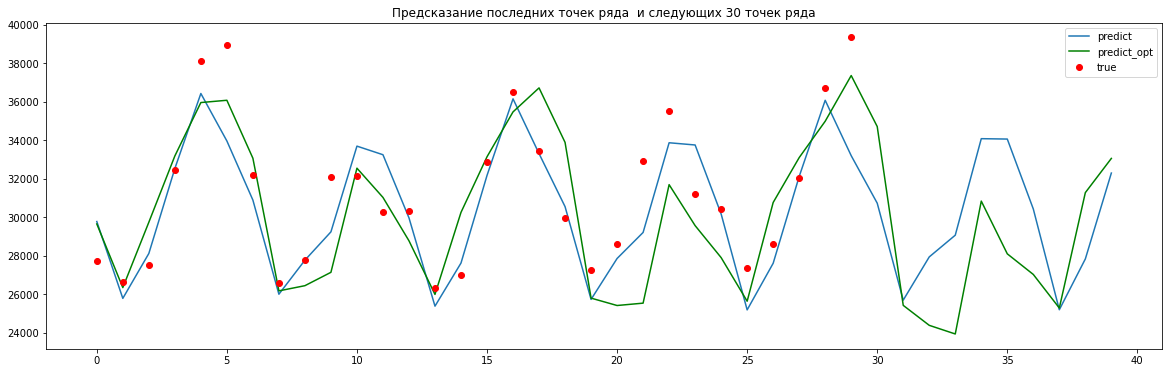

In [29]:
 
pred_dynamic = results.forecast(nforecast)    #делаем предсказание на 30 точtк от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(nforecast)

plt.figure(figsize=(20,6))
plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-N2:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

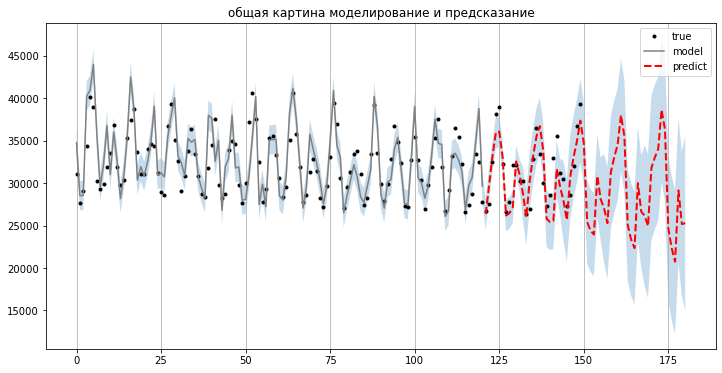

In [30]:
N3=50
nforecast = N2+30  # общее число точек для предсказания (N2 - тестовых точек + точки для чистого предсказания)
predict_ = results_opt.get_prediction(end=results_opt.nobs + nforecast)  # делаем предсказание

# отображаем
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data_m['PJME_MW'].values[N3+N1:], 'k.',label='true')

# 
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], 'gray',label = 'model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()
ax.set(title='общая картина моделирование и предсказание');

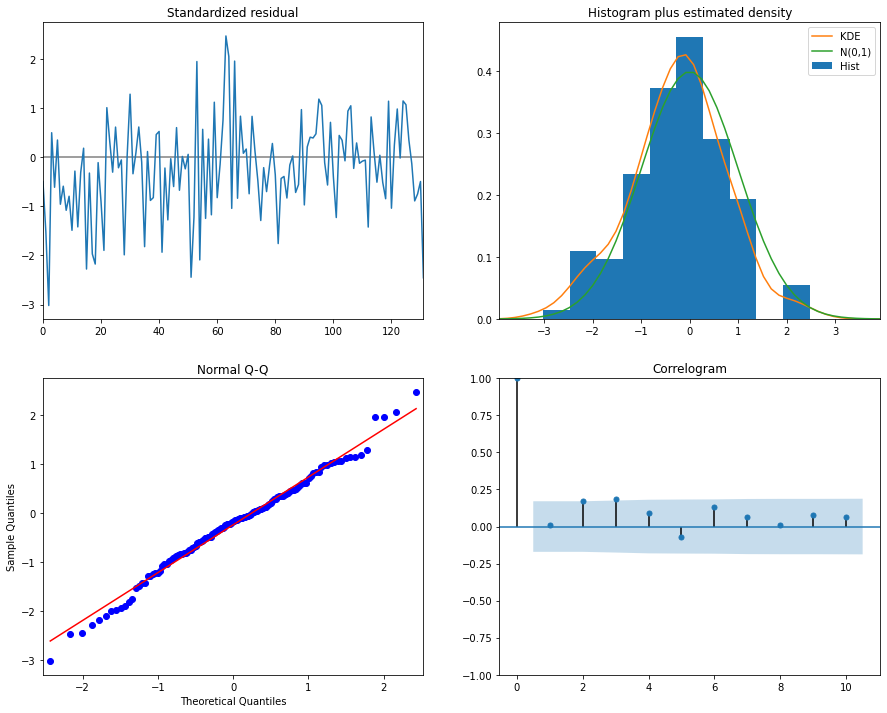

In [31]:
results_opt.plot_diagnostics(figsize=(15, 12))
plt.show()

Видим, что распределение остатков по всем графикам не идеальное, и модель можно было бы доработать

# Задача 3

Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)

In [46]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])

In [47]:
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [49]:
data_w = brent_data.resample('W').mean()

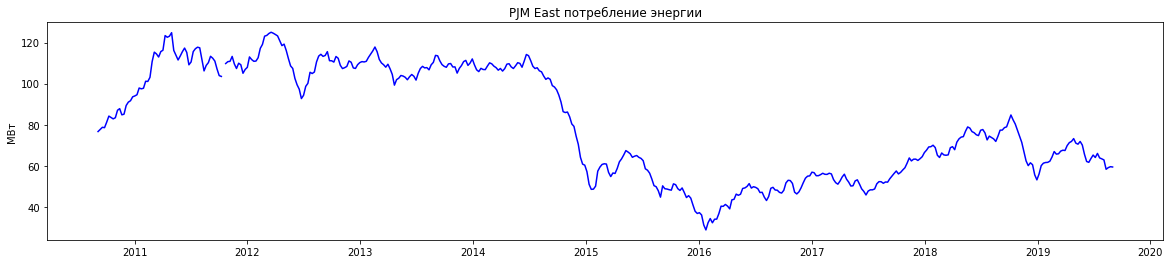

In [51]:
plt.figure(figsize =(20,4))
plt.plot( data_w.index, data_w['Значение'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

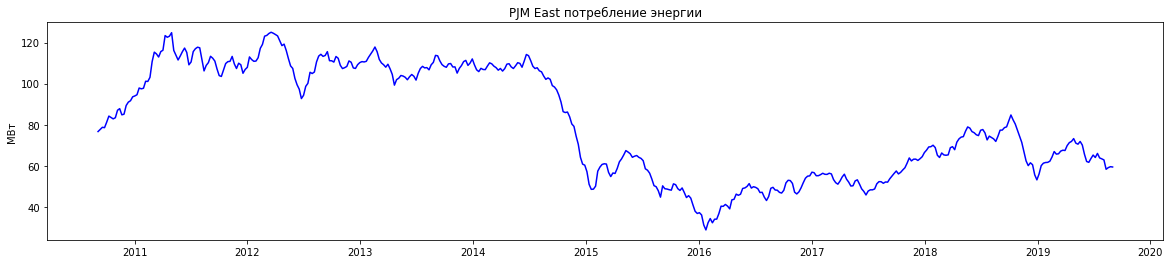

In [123]:
plt.figure(figsize =(20,4))
plt.plot( data_w.index, data_w['Значение'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

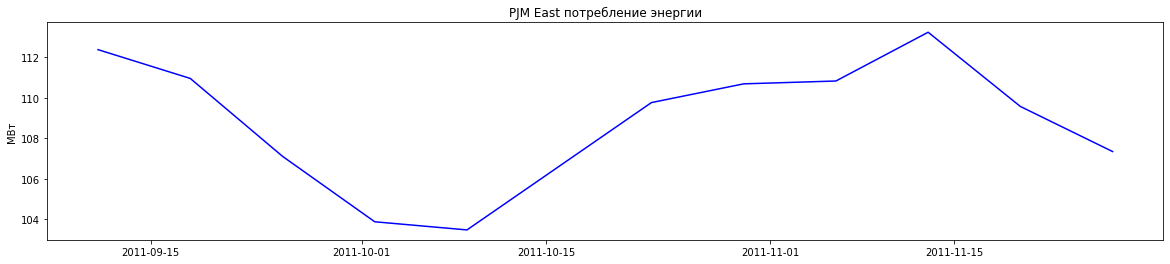

In [73]:
plt.figure(figsize =(20,4))
plt.plot( data_w['2011-09-10':'2011-12-01'].index, data_w['2011-09-10':'2011-12-01']['Значение'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Видим разрыв, надо полечить 

Лечим линейной интерполяцией из пакета sklearn

In [71]:
data_w['2011-09-10':'2011-12-01']['Значение'].interpolate(method='linear', inplace=True)

Проверяем на пропущенные значения 

In [118]:
data_w.isna().sum()

Значение           0
year               0
month              0
dayofmonth         0
quarter            0
dayofyear          0
weekofyear         0
dayofweek          0
is_holiday         0
is_prev_holiday    0
is_next_holiday    0
dtype: int64

In [95]:
data_w = data_w.fillna(0)

In [116]:
data_w  = data_w.replace([np.inf, -np.inf], 0)

In [120]:
np.isinf(data_w).sum()

Значение           0
year               0
month              0
dayofmonth         0
quarter            0
dayofyear          0
weekofyear         0
dayofweek          0
is_holiday         0
is_prev_holiday    0
is_next_holiday    0
dtype: int64

Построим графики автокореляций

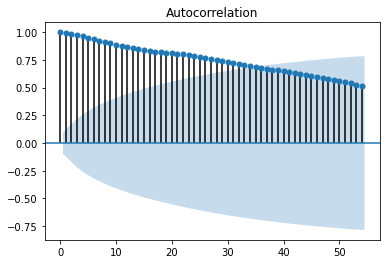

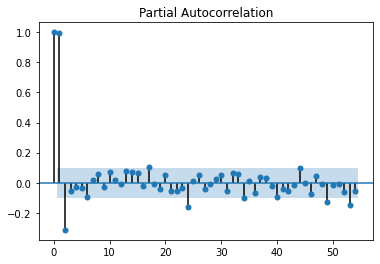

In [142]:
sm.graphics.tsa.plot_acf(data_w['Значение'].values[75:], lags=54)
plt.show()

sm.graphics.tsa.plot_pacf(data_w['Значение'].values[75:], lags=54)
plt.show()

Построим ACF и PACF для первых разностей

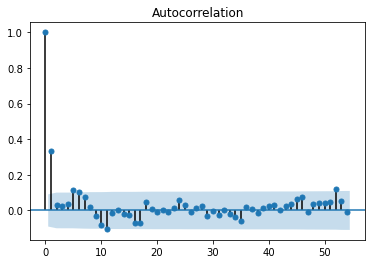

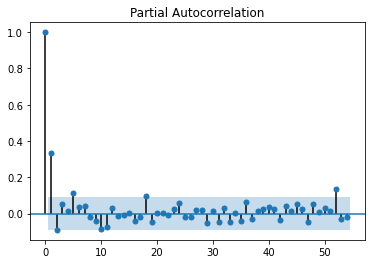

In [87]:
brent_dif = data_w['Значение'].diff(1)

sm.graphics.tsa.plot_acf(brent_dif[1:], lags=54)
plt.show()
 
sm.graphics.tsa.plot_pacf(brent_dif[1:], lags=54)
plt.show()

Видим, что для первой разности кореляции почти нет. Можно предположить что ряд стационарен 

In [88]:
# ARIMA пример
from statsmodels.tsa.arima_model import ARIMA
from random import random
# модельный ряд
 
N=10    # число точек для теста
data_w[:-N]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.200000,0.000000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.000000,0.166667
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.000000,0.000000
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.000000,0.000000
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-26,70.040000,2019.0,5.000000,22.666667,2.000000,142.666667,21.0,2.666667,0.000000,0.166667,0.000000
2019-06-02,65.536667,2019.0,5.166667,24.500000,2.000000,149.666667,22.0,2.666667,0.166667,0.000000,0.166667
2019-06-09,62.026667,2019.0,6.000000,5.666667,2.000000,156.666667,23.0,2.666667,0.000000,0.000000,0.000000


In [162]:
data_w[75:-N]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2012-02-12,117.163333,2012.0,2.000000,8.666667,1.0,39.666667,6.0,2.666667,0.000000,0.000000,0.000000
2012-02-19,119.078333,2012.0,2.000000,15.666667,1.0,46.666667,7.0,2.666667,0.000000,0.166667,0.000000
2012-02-26,123.106667,2012.0,2.000000,22.666667,1.0,53.666667,8.0,2.666667,0.166667,0.000000,0.166667
2012-03-04,123.461667,2012.0,2.500000,15.166667,1.0,60.666667,9.0,2.666667,0.000000,0.000000,0.000000
2012-03-11,124.413333,2012.0,3.000000,7.666667,1.0,67.666667,10.0,2.666667,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-26,70.040000,2019.0,5.000000,22.666667,2.0,142.666667,21.0,2.666667,0.000000,0.166667,0.000000
2019-06-02,65.536667,2019.0,5.166667,24.500000,2.0,149.666667,22.0,2.666667,0.166667,0.000000,0.166667
2019-06-09,62.026667,2019.0,6.000000,5.666667,2.0,156.666667,23.0,2.666667,0.000000,0.000000,0.000000


In [174]:
# строим модель
model = ARIMA(data_w[75:-N].values.reshape(-1).tolist(), order=(2, 1,2))

In [175]:
model_fit = model.fit(disp=False)

In [176]:
# делаем оценку старых значений
y_p = model_fit.predict(len(data_w[75:-N]), len(data_w[75:-N]), typ='levels')
y_f = model_fit.forecast(2*N)

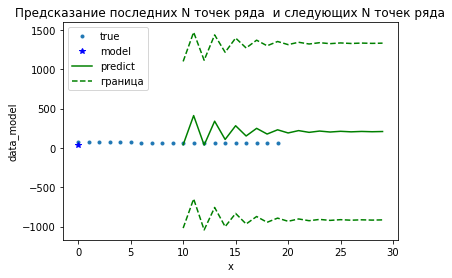

In [178]:
plt.plot(data_w['Значение'][-10-N:].values,'.',label ='true')
plt.plot(y_p,'*b',label ='model')
plt.plot(np.arange(2*N)+N,y_f[0],'g',label ='predict')
plt.plot(np.arange(2*N)+N,y_f[2][:,1],'--g', label = 'граница')
plt.plot(np.arange(2*N)+N,y_f[2][:,0],'--g')
plt.xlabel('x')
plt.ylabel('data_model')
plt.title('Предсказание последних N точек ряда  и следующих N точек ряда')
plt.legend()
plt.show()